<a href="https://colab.research.google.com/github/aka-gera/Data_Classification/blob/main/wine_quality_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASSIFIER**

*This algorithm will identify the optimal classification machine learning model for a given dataset.*

This dataset is provided by: https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

In [2]:
data_dir = f'yasserh/wine-quality-dataset'

# Import Dataset

In [3]:
! pip install kaggle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pwd
%cd /content

/content
/content


In [6]:
! mkdir ~/.kaggle

In [7]:
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download {data_dir}

Dataset URL: https://www.kaggle.com/datasets/yasserh/wine-quality-dataset
License(s): CC0-1.0
  0% 0.00/21.5k [00:00<?, ?B/s]
100% 21.5k/21.5k [00:00<00:00, 9.45MB/s]


In [10]:
import os
file_names = os.listdir()
zip_file =   [file for file in file_names if file.endswith('.zip')]
zip_file

['wine-quality-dataset.zip']

In [11]:
import zipfile

# Open the zip file
with zipfile.ZipFile(zip_file[-1], 'r') as zip_ref:
    zip_ref.extractall()
    unzipped_file_names = zip_ref.namelist()
unzipped_file_names

['WineQT.csv']

# Import the helper classes

In [12]:
!pwd
%cd /content/drive/MyDrive/ML2023/data-analysis

/content
/content/drive/MyDrive/ML2023/data-analysis


In [13]:
!pip install AutoLogging-ML
!pip install xgboost
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.8 MB/s eta 0:00:00


In [14]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from plotly.subplots import make_subplots
from AutoLogging_ML import AutoLogger
import seaborn as sns

from aka_data_analysis.aka_plot import aka_plot, aka_correlation_analysis
from aka_data_analysis.aka_learning import aka_learn,aka_clean,aka_filter

aka_plot = aka_plot()
aka_corr_an = aka_correlation_analysis()
aka_clean = aka_clean()
aka_learn = aka_learn()
aka_filter = aka_filter()
aka_corr_an = aka_correlation_analysis()

In [15]:
from aka_data_analysis.aka_nn import aka_nn

In [16]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
import pandas as pd


# Dataset Information

In [54]:
df = aka_clean.df_get(f'/content/{unzipped_file_names[0]}')

In [55]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [57]:
fig = aka_plot.Plot_histogram_Features(df,[0,1,2,-2,-1] )
if fig is not None:
    fig.show()

In [58]:
aka_plot.plot_pie(df,-2)

In [59]:

df_f =df[df.columns[-2]]
df[df.columns[-2]] = df_f[df_f<5]=5
df[df.columns[-2]] = df_f[df_f>7]=7

In [60]:
aka_plot.plot_pie(df,-2)

In [61]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.682415,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.703828,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,5.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,7.000000,1597.000000


# Clean Dataset

## Drop Duplicate data

In [62]:
df.drop_duplicates()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


## Swap the target and the last feature

In [63]:
df = aka_clean.swap_features(df,11)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Id,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,4,5


### Drop feature(s)


In [64]:
feat =  [11]
df = aka_clean.drop_feature(df,feat)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [65]:
aka_clean.Replace_item_into_str_df(df,col=-1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,_5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,_5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,_5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,_6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,_5


##  Convert categorical variables into numerical representations

In [66]:
mapping,swapMapping = aka_clean.CleaningVar(df)
df = aka_clean.CleaningDF(df,mapping)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


## Balance Dataset

In [67]:
aka_plot.plot_pie(df,-1)

In [68]:
# df = aka_clean.balance_df(df,'j')
# aka_plot.plot_pie(df, -1)

## Correlation Matrix

In [69]:
aka_corr_an.Plot_Correlation_Matrix(df)

In [70]:

confidence_interval_limit =   [-9,9]             # Define the limits m of the confidence interval [-m, m] and eliminate the outliers'''

correlation_percentage_threshold = .5      # Set the limit of the correlation between the feature to be removed

df_filtered,corr_tmp = aka_learn.filter_drop_corr_df(df,confidence_interval_limit,correlation_percentage_threshold)

print(f'We dropped {df.shape[0]-df_filtered.shape[0]} outliers and remove {df.shape[1]-df_filtered.shape[1]} feature(s)')
print(f'The filtered dataset\'s shape is {df_filtered.shape} ')

We dropped 4 outliers and remove 5 feature(s)
The filtered dataset's shape is (1139, 7) 


In [71]:
aka_plot.plot_pie(df_filtered,-1)

## Graph the features that are highly correlated


In [72]:
fig = aka_corr_an.Plot_Correlate_Features(df,list(corr_tmp))
if fig is not None:
    fig.show()

### Visualize the distribution of the filtered dataset

In [73]:
aka_plot.Plot_box_Features(df,df_filtered,corr_tmp=range(df_filtered.shape[1]))

# Search for the most effective ML algorithm to learn the dataset

In [74]:
pre_proc = 'X'                             # Choose between 'XY' to standardize both 'X' and 'Y',
                                              #                'X' to standardize only 'X',
                                              #                'Y' to standardize only 'Y',

X_train, X_test, y_train, y_test = aka_learn.Learning_data(df_filtered,pre_proc)

In [75]:
r,model =AutoLogger.train_and_log_classification(X_train,y_train,X_test,y_test,size='large')
y_pred = model.predict(X_test)

In [76]:
model

ExtraTreesClassifier()

<Axes: xlabel='validation-accuracy', ylabel='model'>

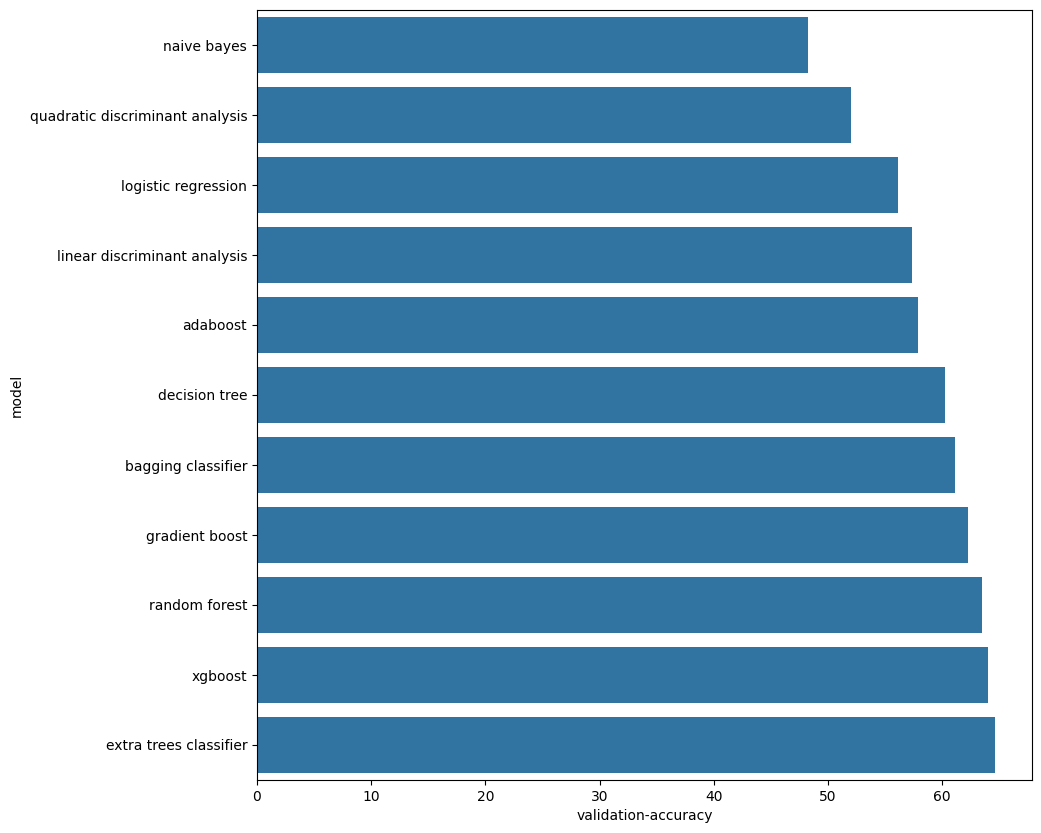

In [77]:
AutoLogger.get_metric_plot_classification(r,'validation','accuracy')

## Confusion Matrix

In [78]:
y_pred_ = aka_clean.swap_map(y_pred,swapMapping)
y_test_ = aka_clean.swap_map(y_test,swapMapping)
Label = [str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]

In [79]:
Label[0],Label[1],Label[2]= 'x <= 5','x = 6','x >= 7'

In [80]:
fig2 =  aka_plot.plot_confusion_matrix(y_test_,y_pred_,Label)
fig2.show()

## Classification Report

In [81]:
fig3 =  aka_plot.plot_classification_report(y_test_,y_pred_,Label)
fig3.show()

## Plot Important Features by Weight

In [82]:
aka_plot.plot_important_features(model,df_filtered)

# Neural Net

## Neural Network Parameters

In [83]:
activation = 'relu'
epoch = 10
num_nodes = [2,4]
dropout_prob = [0.05,0.1]
lr = [0.01,0.1]
batch_size = [2,4]

In [84]:

myNN = aka_nn(X_train, X_test, y_train, y_test,activation)
model,scre =myNN.DNN(epoch,num_nodes,dropout_prob,lr,batch_size)
y_pred = myNN.predict(model)

2 nodes, dropout 0.05, lr 0.01, batch size 2
11/11 [==============================] - 0s 3ms/step - loss: 0.3877 - accuracy: 0.4152
2 nodes, dropout 0.05, lr 0.01, batch size 4
11/11 [==============================] - 0s 3ms/step - loss: 0.3653 - accuracy: 0.5175
2 nodes, dropout 0.05, lr 0.1, batch size 2
11/11 [==============================] - 0s 2ms/step - loss: 0.4737 - accuracy: 0.4152
2 nodes, dropout 0.05, lr 0.1, batch size 4
11/11 [==============================] - 0s 2ms/step - loss: 0.5508 - accuracy: 0.4591
2 nodes, dropout 0.1, lr 0.01, batch size 2
11/11 [==============================] - 0s 2ms/step - loss: 0.3848 - accuracy: 0.5585
2 nodes, dropout 0.1, lr 0.01, batch size 4
11/11 [==============================] - 0s 4ms/step - loss: 0.3558 - accuracy: 0.5906
2 nodes, dropout 0.1, lr 0.1, batch size 2
11/11 [==============================] - 0s 2ms/step - loss: 0.5716 - accuracy: 0.4152
2 nodes, dropout 0.1, lr 0.1, batch size 4
11/11 [==============================] 

## Confusion Matrix

In [85]:
y_pred_ = aka_clean.swap_map(y_pred,swapMapping)
y_test_ = aka_clean.swap_map(y_test,swapMapping)
# Label = [str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]

In [86]:
fig2 =  aka_plot.plot_confusion_matrix(y_test_,y_pred_,Label)
fig2.show()

## Classification Report

In [87]:
fig3 =  aka_plot.plot_classification_report(y_test_,y_pred_,Label)
fig3.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

